In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
%cd /content/drive/MyDrive/test_set

/content/drive/MyDrive/test_set


In [17]:
!ls

In [18]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils

Cloning into 'yolov5'...
remote: Enumerating objects: 12338, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 12338 (delta 0), reused 1 (delta 0), pack-reused 12335
Receiving objects: 100% (12338/12338), 12.13 MiB | 9.67 MiB/s, done.
Resolving deltas: 100% (8513/8513), done.
/content/drive/MyDrive/test_set/yolov5


In [19]:
# install dependencies as necessary
import torch

from IPython.display import Image, clear_output  # to display images


# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [20]:
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [21]:
!curl -L "https://app.roboflow.com/ds/ks37QC6xeX?key=2EvEC4HtVB" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   893  100   893    0     0   3488      0 --:--:-- --:--:-- --:--:--  3488
100  525k  100  525k    0     0  1257k      0 --:--:-- --:--:-- --:--:-- 1257k
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/10_bmp.rf.2452f64b78a6f1ba9e80ee3aafd4a528.jpg  
 extracting: test/images/14_bmp.rf.a4a6144f65a8167df7f60bf683014e62.jpg  
 extracting: test/images/21_bmp.rf.e65cc052e793ad6ec69436b76985db20.jpg  
 extracting: test/images/4_bmp.rf.4e3fbe4d2cc31abf2abefe59efe2ed90.jpg  
 extracting: test/images/8_bmp.rf.95f6dec4768a9f8336fcdbe9e7b8f24b.jpg  
   creating: test/labels/
 extracting: test/labels/10_bmp.rf.2452f64b78a6f1ba9e80ee3aafd4a528.txt  
 extracting: test/labels/14_bmp.rf

In [22]:
%ls

CONTRIBUTING.md  export.py   README.dataset.txt   setup.cfg  tutorial.ipynb
data/            hubconf.py  README.md            test/      utils/
data.yaml        LICENSE     README.roboflow.txt  train/     valid/
detect.py        models/     requirements.txt     train.py   val.py


In [23]:
%cat /content/yolov5/data.yaml

train: ./train/images
val: ./valid/images

nc: 6
names: ['can', 'cap', 'cap-ring', 'glass', 'label', 'pet']

In [7]:
# define number of classes based on YAML
import yaml
with open("/content/yolov5/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])
num_classes

'6'

In [8]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [9]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
# !pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html

In [24]:
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images


detect: weights=['yolov5s.pt'], source=data/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-269-gf76a78e Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

100% 14.1M/14.1M [00:00<00:00, 105MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/drive/MyDrive/test_set/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.018s)
image 2/2 /content/drive/MyDrive/test_set/yolov5/data/images/zidane.jpg: 384x640 2 persons, 2 ties, Done. (0.022s)
Speed: 0.5ms pre-process, 19.7ms inference, 1.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


In [11]:
%cat data.yaml

train: ./train/images
val: ./valid/images

nc: 6
names: ['can', 'cap', 'cap-ring', 'glass', 'label', 'pet']

In [30]:
!ls

content		 export.py    README.dataset.txt   setup.cfg	   utils
CONTRIBUTING.md  hubconf.py   README.md		   test		   valid
data		 LICENSE      README.roboflow.txt  train	   val.py
data.yaml	 models       requirements.txt	   train.py	   yolov5
detect.py	 __pycache__  runs		   tutorial.ipynb  yolov5s.pt


In [26]:
!python ./train.py --img 640 --batch 16 --epochs 200 --data ./data.yaml --weights ./yolov5s.pt --cache

train: weights=./yolov5s.pt, cfg=, data=./data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-269-gf76a78e Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degree

In [31]:
!python3 detect.py --weights ./runs/train/exp2/weights/best.pt --source /content/yolov5/train/images/

detect: weights=['./runs/train/exp2/weights/best.pt'], source=/content/yolov5/train/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-269-gf76a78e Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7026307 parameters, 0 gradients
image 1/27 /content/yolov5/train/images/10_bmp.rf.59a16f850f7d6be4f271c78e1f2abde8.jpg: 640x640 1 cap, 1 pet, Done. (0.013s)
image 2/27 /content/yolov5/train/images/11_bmp.rf.4b02a210f3eb415d66f25eaf1125ff3f.jpg: 640x640 1 cap, 1 label, 1 pet, Done. (0.013s)
image 3/27 /content/yolov5/train/images/11_bmp.rf.e658fa099e0440f4d9967faf7d942684.jpg: 640x640 1 cap

In [19]:
!pip install utils
!pip install torchvision
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
!python3 detect.py --weights ./runs/train/exp2/weights/best.pt --source /content/yolov5/test/images/

detect: weights=['./runs/train/exp2/weights/best.pt'], source=/content/yolov5/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-269-gf76a78e Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 213 layers, 7026307 parameters, 0 gradients
image 1/5 /content/yolov5/test/images/10_bmp.rf.2452f64b78a6f1ba9e80ee3aafd4a528.jpg: 640x640 1 cap, 1 label, 1 pet, Done. (0.013s)
image 2/5 /content/yolov5/test/images/14_bmp.rf.a4a6144f65a8167df7f60bf683014e62.jpg: 640x640 1 cap, 1 glass, 1 label, Done. (0.013s)
image 3/5 /content/yolov5/test/images/21_bmp.rf.e65cc052e793ad6ec69436b76985db20.jpg: 640x640 1

In [35]:
!pip install utils
!pip install torchvision
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!sudo find / -iname torch

find: ‘/proc/30/task/30/net’: Invalid argument
find: ‘/proc/30/net’: Invalid argument
/usr/local/lib/python3.7/dist-packages/torch
/usr/local/lib/python3.7/dist-packages/torch/include/torch
/usr/local/lib/python3.7/dist-packages/torch/include/torch/csrc/api/include/torch
/usr/local/lib/python3.7/dist-packages/torch/share/cmake/Torch
/usr/local/lib/python3.7/dist-packages/albumentations/torch
/usr/local/lib/python3.7/dist-packages/gin/torch
^C


In [ ]:
import torch

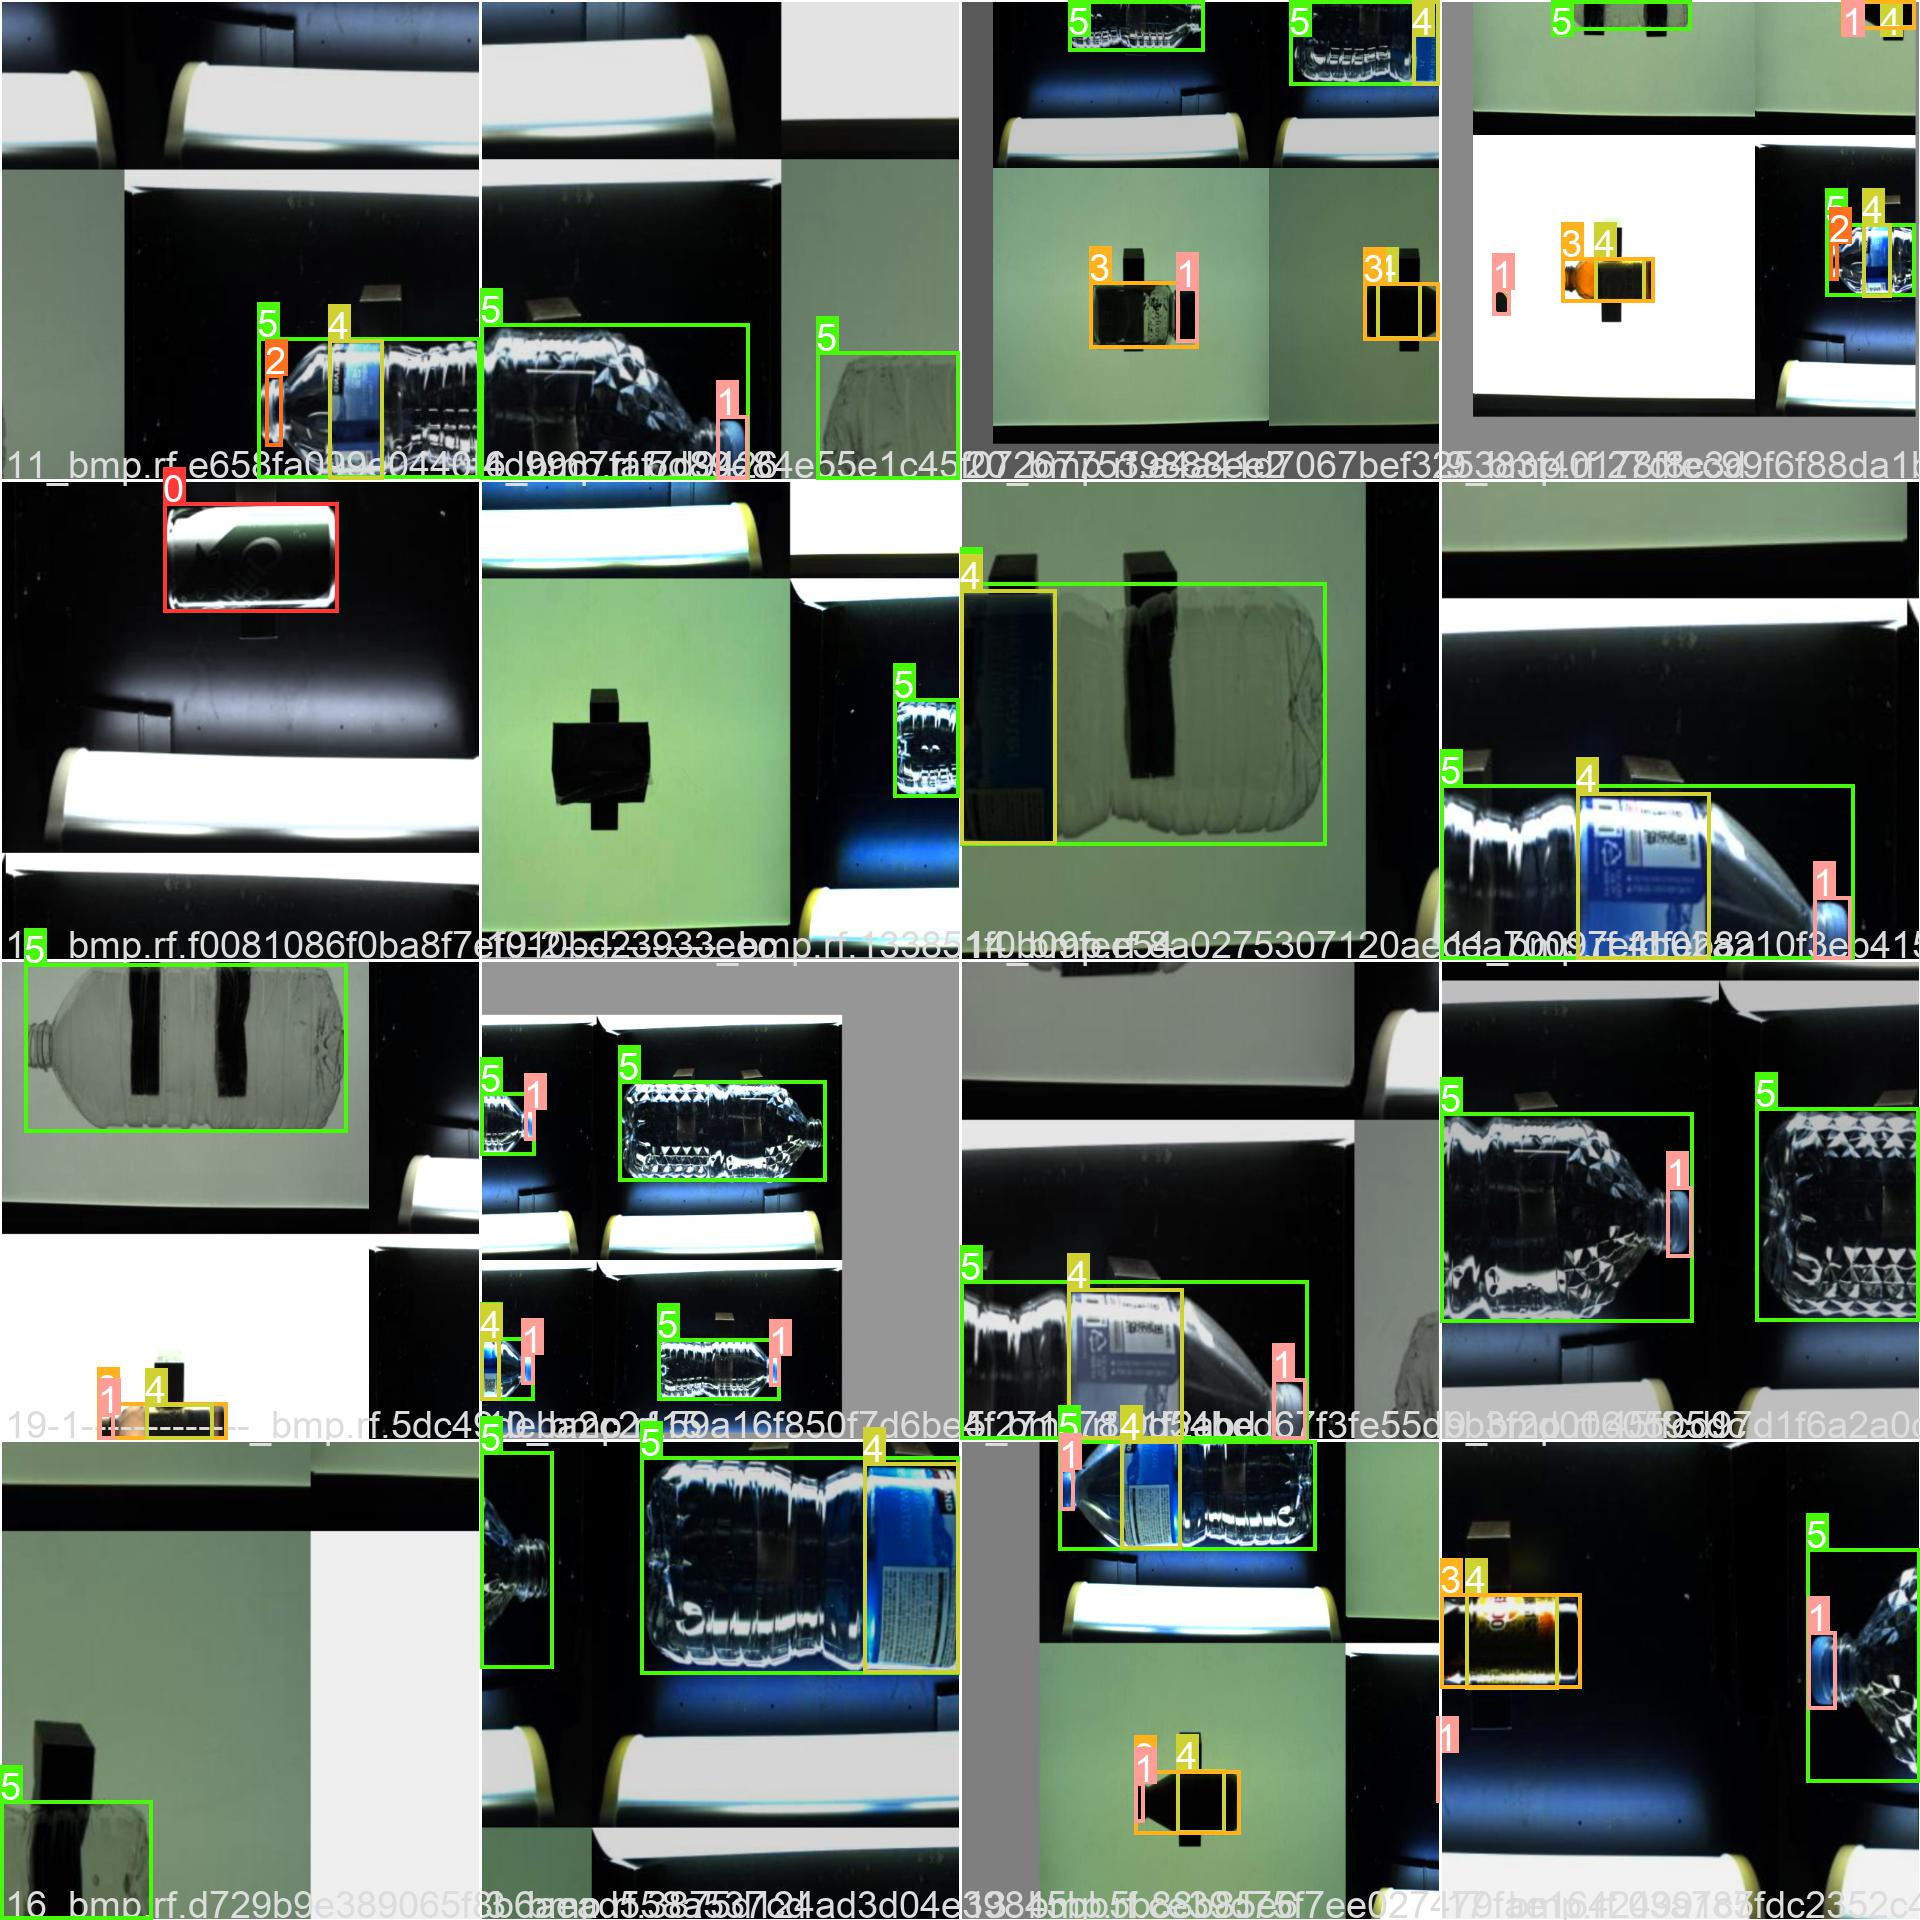

In [38]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
import torch

from IPython.display import Image, clear_output  # to display images

Image(filename='/content/drive/MyDrive/test_set/yolov5/runs/train/exp2/train_batch2.jpg', width=1000)  # view results.png
Image(filename='/content/drive/MyDrive/test_set/yolov5/runs/train/exp2/train_batch0.jpg', width=1000)

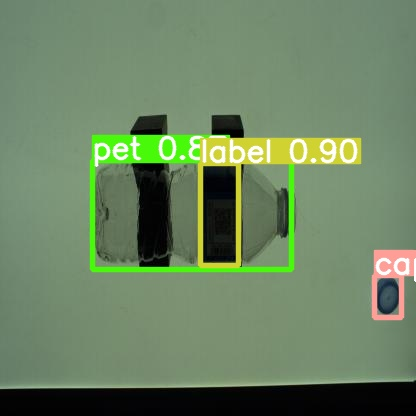

In [40]:
Image(filename='/content/drive/MyDrive/test_set/yolov5/runs/detect/exp5/12_bmp.rf.cecad99a82f3ea8a00ed9e87d0d7c79c.jpg')

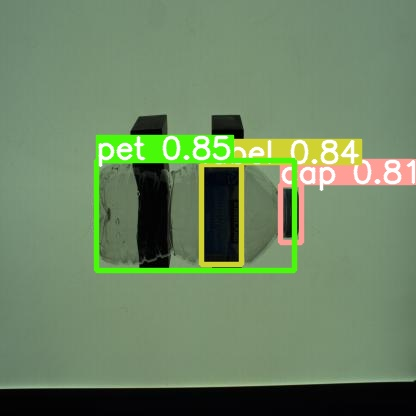

In [41]:
# test
Image(filename='/content/drive/MyDrive/test_set/yolov5/runs/detect/exp6/10_bmp.rf.2452f64b78a6f1ba9e80ee3aafd4a528.jpg')